In [1]:
import os, getpass
from dotenv import load_dotenv
load_dotenv("../../.env")

True

In [2]:
from langchain_openai import ChatOpenAI

# Prompts we will use
drivers_prompt = """Generate a list of 3 top drivers for this race: {race_name}."""
lap_time_prompt = """Generate a simulated qualifying lap time for {driver} at this track.
Format: 'Driver: [Driver], Lap Time: [M:SS.mmm]'"""
pole_position_prompt = """Below are several qualifying lap times for {race_name}. Select the fastest one (Pole Position)!
Return the ID of the fastest one, starting 0 as the ID for the first lap.
Laps: \n\n  {laps}"""

# LLM
model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [3]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Drivers(BaseModel):
    drivers: list[str]

class PolePosition(BaseModel):
    id: int

class RaceQualiState(TypedDict):
    race_name: str
    drivers: list
    laps: Annotated[list, operator.add]
    pole_lap: str

In [4]:
def get_drivers(state: RaceQualiState):
    prompt = drivers_prompt.format(race_name=state["race_name"])
    response = model.with_structured_output(Drivers).invoke(prompt)
    return {"drivers": response.drivers}

In [5]:
from langgraph.types import Send
def continue_to_laps(state: RaceQualiState):
    return [Send("simulate_lap", {"driver": d}) for d in state["drivers"]]

In [6]:
class LapSimState(TypedDict):
    driver: str

class LapTime(BaseModel):
    lap_time: str

def simulate_lap(state: LapSimState):
    prompt = lap_time_prompt.format(driver=state["driver"])
    response = model.with_structured_output(LapTime).invoke(prompt)
    return {"laps": [response.lap_time]}

In [7]:
def get_pole_position(state: RaceQualiState):
    laps = "\n\n".join(state["laps"])
    prompt = pole_position_prompt.format(race_name=state["race_name"], laps=laps)
    response = model.with_structured_output(PolePosition).invoke(prompt)
    return {"pole_lap": state["laps"][response.id]}

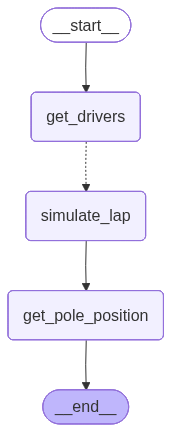

In [8]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(RaceQualiState)
graph.add_node("get_drivers", get_drivers)
graph.add_node("simulate_lap", simulate_lap)
graph.add_node("get_pole_position", get_pole_position)
graph.add_edge(START, "get_drivers")
graph.add_conditional_edges("get_drivers", continue_to_laps, ["simulate_lap"])
graph.add_edge("simulate_lap", "get_pole_position")
graph.add_edge("get_pole_position", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [9]:
# Call the graph: here we call it to generate a list of lap times
for s in app.stream({"race_name": "Monaco Grand Prix"}):
    print(s)

{'get_drivers': {'drivers': ['Max Verstappen', 'Lewis Hamilton', 'Charles Leclerc']}}
{'simulate_lap': {'laps': ['Driver: Max Verstappen, Lap Time: 1:12.345']}}
{'simulate_lap': {'laps': ['Driver: Charles Leclerc, Lap Time: 1:12.345']}}
{'simulate_lap': {'laps': ['Driver: Lewis Hamilton, Lap Time: 1:12.345']}}
{'get_pole_position': {'pole_lap': 'Driver: Max Verstappen, Lap Time: 1:12.345'}}
